In [1]:
# Created modules are in 'code' folder
import sys
sys.path.append('./code')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from neuralnetwork import MultiClassNeuralNetwork as nn
from grad_check import GradientCheck
from load_dataset import LoadData 
import os
import random
import warnings
import pickle
import pandas as pd
import cv2
import re
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings("ignore")

## Loading the Data Set
- Here we load and visualize the weather data.

In [2]:
# This function will unzip images and split it into training e dev sets
current_working_directory = os.getcwd()
path_zip = current_working_directory +  "\\dataset.zip"
extract_files_to = current_working_directory 
images_directory = current_working_directory + "\\dataset"
split_rate = [0.8, 0.2]

ld = LoadData()
X_train_orig, y_train, X_test_orig, y_test, classes = ld.load_dataset(path_zip, extract_files_to, images_directory, split_rate)

Copying files: 1125 files [00:16, 69.08 files/s] 


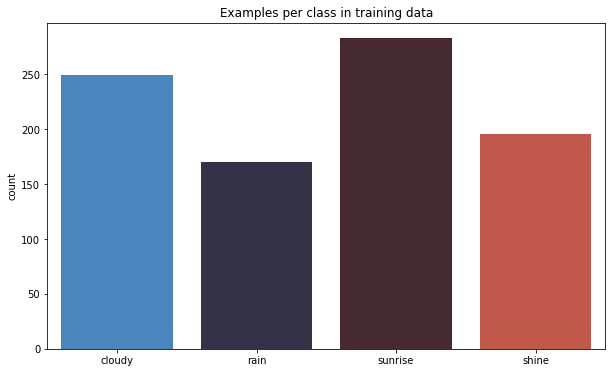

In [3]:
# Visualize number of weather classes
plt.figure(figsize=(10,6))
g = sns.countplot(classes, palette="icefire")
plt.title("Examples per class in training data")
plt.show()

In [4]:
# Data Augmentation
# Since we have a small dataset, let's use data augmentation to increase the amount and diversity of data

# We are going to use ImageDataGenerator (from keras) to do so
datagen = ImageDataGenerator(
    rotation_range=20,
    brightness_range = (0.8, 1.2),
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range=[-20, 20]
)

# The goal is to total 500 images per class
unique, counts = np.unique(y_train, return_counts=True)
counter = dict(zip(unique, counts))
class_labels = np.unique(np.array(classes))


for cl in np.unique(y_train):
    new_data = []
    number_new_imgs = 500 - (counter[cl])

    # Split samples per class
    class_indices = np.where(y_train == cl)[1]
    samples = X_train_orig[class_indices]

    # Prepare iterator
    it = datagen.flow(samples, batch_size=1)
    # Generate data
    for i in range(number_new_imgs):
        batch = it.next()

        image = batch[0].astype('uint8')

        new_data.append(image)
        classes.append(class_labels[cl])

    new_data = np.array(new_data)

    X_train_orig = np.concatenate((X_train_orig, new_data))
    
    new_y = np.repeat(cl, number_new_imgs)
    new_y = new_y.reshape((1, new_y.shape[0]))
    y_train = np.concatenate((y_train, new_y), axis=1)

Class: sunrise


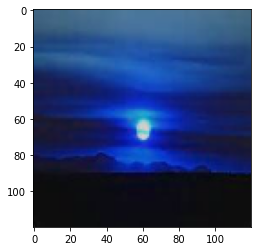

In [5]:
# Visualizing examples
index = random.randrange(0, y_train.shape[1])
plt.imshow(X_train_orig[index])
print("Class: "+ str(classes[index]))

## Reshape and Standardization

In [6]:
# Checking shapes
print("Shape of X - training data: " + str(X_train_orig.shape))
print("Shape of y - training data: " + str(y_train.shape))
print("Shape of X - test data: " + str(X_test_orig.shape))
print("Shape of y - test data: " + str(y_test.shape))

Shape of X - training data: (2000, 120, 120, 3)
Shape of y - training data: (1, 2000)
Shape of X - test data: (225, 120, 120, 3)
Shape of y - test data: (1, 225)


In [7]:
# Note that for each example we have 120 * 120 * 3 values, wich are the RGB values/pixel.
# We now need to reshape X data so that each image is represented as a flattened vector.
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

In [8]:
# AS RGB ranges from 0 to 255, lets stardardize by dividing each row by 255
X_train = X_train_flatten / 255.
X_test = X_test_flatten / 255.

## Neural Network
The algorithm used for this weather classification task was build from scratch using only numpy. It focuses on multiclass classification and allows us to perform a few hyperparameter tuning strategies (NN's architecure, learning rate and number of iterations). The logic behind follows:
1) Parameter initialization (random): Initilizes 'W' and 'b' based on choosen architecture;
2) Gradient descent: Since this is a relatively small data set, the optimization algorithm used is batch gradient descent.
3) Forward propagation: Rectified Linear Unit activation function for all hidden layers and Softmax for output layer.
4) Cost calculation for minimizing purposes.
5) Backward propagation: One hot encodes Y and computes derivatives for Softmax and ReLU layers to update parameters.


**Gradient Checking**
First step is to check if my implementation of backward propagation is correct. Lets do it by checking the numerical approximation of derivatives. 
- The module created for grad check does the following:
    1) Transform parameters from dictionary to vector;
    2) Transform gradients from backward propagation implemented through 'neuralnetwork.py' file;
    3) Compute numerical approximation of derivatives for each value of vector from (1);
    4) Compare gradientes from (2) and (3) by calculating the euclidean distance. 
- If the difference between them is less than 10-7, backward propagation has no bugs.
- Notice before running that it takes more than minutes to finish, once in this process we need to use for loops (giving up the speed of matrices).

In [9]:
# Selecting datapoints
x = X_train[:, 0:10]
y = y_train[:, 0:10]
# NN's Architecure
layer_dims = [x.shape[0], 5, 3, len(np.unique(y))]
# Instantiate NN
neural_network = nn(layer_dims)
# Define parameters
params = neural_network._MultiClassNeuralNetwork__initialize_parameters()
# Compute gradients from backward propagation
AL, caches = neural_network.L_model_forward(x, parameters=params)
gradients = neural_network.L_model_backward(AL, y, caches)
# Compute difference 
gc = GradientCheck(layer_dimensions=layer_dims, parameters=params)
diff = gc.gradient_check_n(gradients, x, y, epsilon=1e-7, print_msg=True)

The difference is acceptable for objectives with kinks (e.g. use of tanh nonlinearities and softmax). Difference = 8.19257754858273e-07


## Training Process 
After trying some architectures combined with different learning rates and number of iterations, results were not satisfactory.
Due to the high flexibility of neural networks and the small amount of data, I had to make two important changes in order to decrease the overfit problem and reduce cost reduction function's oscillation.
- Make use of data augmentation techniques;
- Adjust the NN's algorithm to reduce learning rate throughout the learning process.

In [ ]:
# 5th round of tests:
layers_dims = [X_train.shape[0], 24, 16, 8, len(np.unique(y_train))]

lr = 0.0225

n_iter = 25000

results = {}

# Instantiate the classifier
clf = nn(layers_dims)

# Fit the model
parameters, cost = clf.train_model(
    X_train,
    y_train,
    num_iterations=n_iter,
    learning_rate=lr,
    print_cost=True
)

results["parameters_" + str(layers_dims) +"_learning-rate_" + str(lr)] = parameters
results["cost_" + str(layers_dims) +"_learning-rate_" + str(lr)] = cost

In [10]:
"""Dumping results so we do not have to train again with this configuration. It takes too long."""
# with open('model_artifacts\\training_results.pkl', 'wb') as f:
#     pickle.dump(results, f)

'Dumping results so we do not have to train again with this configuration. It takes too long.'

## Evaluate the model
- Cost values throughout the learning process (visualization);
- Accuracy.

In [11]:
# Load dictionary created with results from multiple training with different architectures and learning rates
with open('model_artifacts\\training_results.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [12]:
# Extract cost data
costs = [ v for k,v in loaded_dict.items() if 'cost' in k]
labels = [ k for k,v in loaded_dict.items() if 'cost' in k]

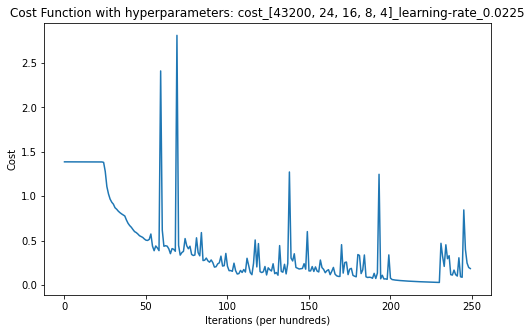

In [13]:
# Plot the cost during training 
plt.figure(figsize=(8,5))
plt.plot(costs[0])
plt.title("Cost Function with hyperparameters: " + labels[0])
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.show()


- It would be okay to stop at 22000 iterations once the cost goes back to fluctuating after holding steady at a low value.

In [14]:
# Calculate accuracy from model:
hyperparams = 'parameters_[43200, 24, 16, 8, 4]_learning-rate_0.0225'
accuracy = {}

parameters = loaded_dict[hyperparams]
layer_dim_str = re.search(r'\[(.*?)\]', hyperparams).group(1)
layer_dim = list(map(int, layer_dim_str.split(',')))
clf = nn(layer_dim)

Y_pred_train, acc_train = clf.predict(X_train, y_train, parameters)
Y_pred_test, acc_test = clf.predict(X_test, y_test, parameters)

accuracy["T_" + str(hyperparams)+"_1st"] = ['Train', round(100*acc_train,2)]
accuracy["D_" + str(hyperparams)+"_1st"] = ['Dev', round(100*acc_test,2)]

In [15]:
# Dataframe to analyze results
results_data = pd.DataFrame.from_dict(
    accuracy, 
    orient='index',
    columns=['Data_set','Accuracy']
)

results_data = results_data.reset_index(level=0).rename(columns={'index': 'Settings'})

results_data['Settings'] = results_data['Settings'].str.split(pat='_parameters_', expand=True)[1]

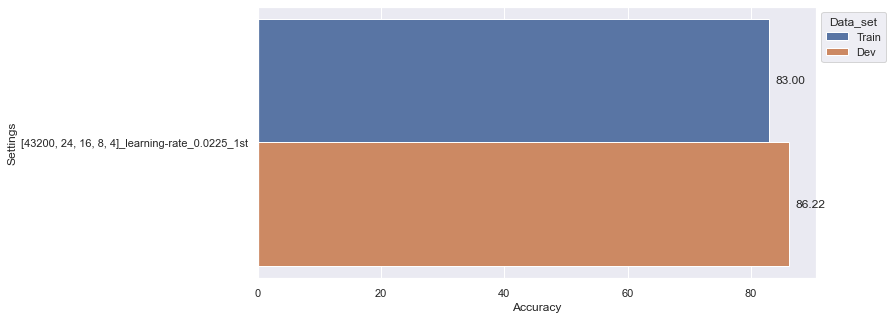

In [16]:
# Data visualization of accuracy results
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.barplot(x="Accuracy", y="Settings", hue="Data_set", data=results_data, orient="h")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

- Since data augmentation process generates images randomly and the parameters from trained model were stored in a pickled dictionary, accuracy from training data is actually 91,75% and not the value shown in chart.
- Therefore there is a difference of 5,53% between training and development (test) sets. 

## Testing with my own image

y = 2, your algorithm predicts a "shine" picture.


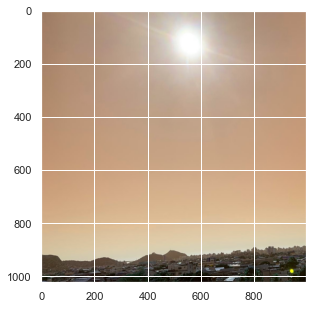

y = 0, your algorithm predicts a "cloudy" picture.


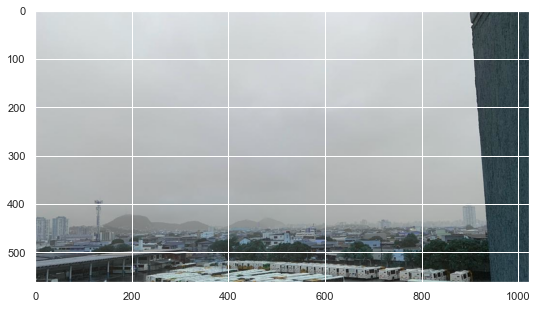

In [17]:
images_path = ".\my_test_images"

for img in os.listdir(images_path):
    fname = img

    # Preprocessing steps:
    orig_image = cv2.imread(os.path.join(images_path, img))
    img_size = 120
    new_array = cv2.resize(orig_image, (img_size, img_size))
    new_array = new_array.reshape(1, 120, 120, 3)
    image = new_array.reshape(new_array.shape[0], -1).T
    normalized_image = image/255.

    # Prediction
    classifier = 'parameters_[43200, 24, 16, 8, 4]_learning-rate_0.0225'
    params = loaded_dict[classifier]
    layer_dim_str = re.search(r'\[(.*?)\]', classifier).group(1)
    layer_dim = list(map(int, layer_dim_str.split(',')))
    clf = nn(layer_dim)

    prediction = clf.make_prediction(normalized_image, params)

    itemindex = np.nonzero(y_train == prediction[0])[1][0]
    predicted_class = classes[itemindex]

    print("y = " + str(np.squeeze(prediction)) + ", your algorithm predicts a \"" + predicted_class +  "\" picture.")
    plt.imshow(orig_image)
    plt.show()